# Unweighted Connected Components
The _Connected Components_ or _UnionFind_ algorithm finds sets of connected nodes in an undirected graph where each node is reachable from any other node in the same set.
It differs from the SCC algorithm because it only needs a path to exist between pairs of nodes in one direction, whereas SCC needs a path to exist in both directions.
As with SCC, UnionFind is often used early in an analysis to understand a graph's structure.

First we'll import the Neo4j driver and Pandas libraries:


In [20]:
from neo4j.v1 import GraphDatabase, basic_auth
import pandas as pd
import os

Next let's create an instance of the Neo4j driver which we'll use to execute our queries.


In [21]:
host = os.environ.get("NEO4J_HOST", "bolt://localhost") 
user = os.environ.get("NEO4J_USER", "neo4j")
password = os.environ.get("NEO4J_PASSWORD", "neo")
driver = GraphDatabase.driver(host, auth=basic_auth(user, password))

Now let's create a sample graph that we'll run the algorithm against.


In [22]:
create_graph_query = '''
MERGE (nAlice:User {id:'Alice'})
MERGE (nBridget:User {id:'Bridget'})
MERGE (nCharles:User {id:'Charles'})
MERGE (nDoug:User {id:'Doug'})
MERGE (nMark:User {id:'Mark'})
MERGE (nMichael:User {id:'Michael'})

MERGE (nAlice)-[:FRIEND {weight:0.5}]->(nBridget)
MERGE (nAlice)-[:FRIEND {weight:4}]->(nCharles)
MERGE (nMark)-[:FRIEND {weight:1}]->(nDoug)
MERGE (nMark)-[:FRIEND {weight:2}]->(nMichael);
'''

with driver.session() as session:
    result = session.write_transaction(lambda tx: tx.run(create_graph_query))
    print("Stats: " + str(result.consume().metadata.get("stats", {})))

Stats: {}


Finally we can run the algorithm by executing the following query:


In [23]:
streaming_query = """
CALL algo.unionFind.stream('User', 'FRIEND', {}) 
YIELD nodeId,setId

MATCH (u:User) WHERE id(u) = nodeId

RETURN u.id AS user, setId
"""

with driver.session() as session:
    result = session.read_transaction(lambda tx: tx.run(streaming_query))        
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())

df

,user,setId
0,Alice,0
1,Bridget,0
2,Charles,0
3,Doug,4
4,Mark,4
5,Michael,4


We have two distinct group of users that have no link between them.
The first group contains Alice, Charles, and Bridget, while the second group contains Michael, Doug, and Mark.

We can also call a version of the algorithm that will store the result as a property on a
node. This is useful if we want to run future queries that use the result.

In [24]:
write_query = """
CALL algo.unionFind('User', 'FRIEND', {write:true, partitionProperty:"partition"}) 
YIELD nodes, setCount, loadMillis, computeMillis, writeMillis;
"""

with driver.session() as session:
    session.write_transaction(lambda tx: tx.run(write_query))

## Graph Visualisation

Sometimes a picture can tell more than a table of results and this is often the case with graph algorithms. 
Let's see how to create a graph visualization using neovis.js.

First we'll create a div into which we will generate the visualisation.

In [25]:
%%html
<style type="text/css">                
.output_wrapper, .output {
    height:auto !important;
    max-height:600px;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}

#viz {
    width: 300px;
    height: 350px;
    font: 22pt arial;
}
</style>  
<div id="viz"></div>

Next we need to define the query that the visualization will be generated from, along with config 
that describes which properties will be used for node size, node colour, and relationship width. 

We'll then define a JavaScript variable that contains all our parameters.

In [26]:
from IPython.core.display import Javascript
import json
from scripts.algo import viz_config, render_image

config = viz_config("Unweighted Connected Components")
query = config["query"]
labels_json = config["labels_json"]
relationships_json = config["relationships_json"]

json_graph = {
    "query": query,
    "labels": labels_json,
    "relationships": relationships_json,
    "host": host,
    "user": user,
    "password": password
}

Javascript("""window.jsonGraph={};""".format(json.dumps(json_graph)))

<IPython.core.display.Javascript object>

Now we're ready to call neovis.js and generate our graph visualisation. 
The following code will create an interactive graph into the div defined above.
It will also extract an image representation of the graph and display that in the cell below.

In [27]:
%%javascript
var output_area = this;
requirejs(['neovis.js'], function(NeoVis){    
    var config = {
      container_id: "viz",
      server_url: window.jsonGraph.host,
      server_user: window.jsonGraph.user,
      server_password: window.jsonGraph.password,
      labels: window.jsonGraph.labels,
      relationships: window.jsonGraph.relationships,
      initial_cypher: window.jsonGraph.query
    };
        
    let viz = new NeoVis.default(config);
    viz.render();
    
    viz.onVisualizationRendered(function(ctx) {
      let imageSrc = ctx.canvas.toDataURL();
      let kernel = IPython.notebook.kernel;
      let command = "image_src = '" + imageSrc + "'";
      kernel.execute(command);
      
      var cell_element = output_area.element.parents('.cell');
      var cell_idx = Jupyter.notebook.get_cell_elements().index(cell_element);
      var cell = Jupyter.notebook.get_cell(cell_idx+1);
      cell.set_text("render_image(image_src)")
      cell.execute();
    });
});

<IPython.core.display.Javascript object>


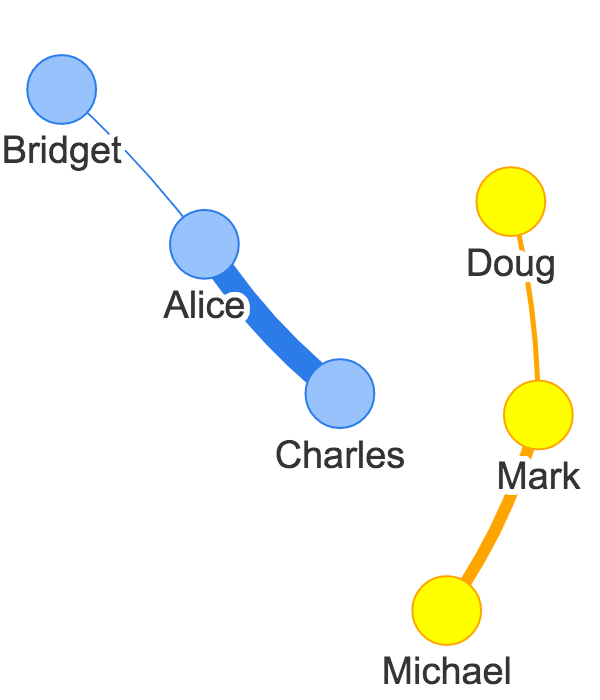

In [29]:
render_image(image_src)